In [1]:
import datetime
import random
from datetime import timedelta

from sklearn.preprocessing import StandardScaler, RobustScaler

from core.composer.gp_composer.gp_composer import \
    GPComposer, GPComposerRequirements
from core.composer.visualisation import ComposerVisualiser
from core.repository.model_types_repository import ModelTypesRepository
from core.repository.quality_metrics_repository import \
    ClassificationMetricsEnum, MetricsRepository
from core.repository.tasks import Task, TaskTypesEnum
from core.utils import probs_to_labels
from examples.utils import create_multi_clf_examples_from_excel


import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from benchmark.benchmark_utils import get_scoring_case_data_paths
from core.composer.chain import Chain
from core.composer.node import PrimaryNode, SecondaryNode
from core.models.data import InputData

random.seed(1)
np.random.seed(1)


def get_model(train_file_path: str, cur_lead_time: datetime.timedelta = timedelta(minutes=5)):
    task = Task(task_type=TaskTypesEnum.classification)
    dataset_to_compose = InputData.from_csv(train_file_path, task=task)

    # the search of the models provided by the framework
    # that can be used as nodes in a chain for the selected task
    models_repo = ModelTypesRepository()
    available_model_types, _ = models_repo.suitable_model(task_type=task.task_type)

    metric_function = MetricsRepository(). \
        metric_by_id(ClassificationMetricsEnum.ROCAUC_penalty)

    composer_requirements = GPComposerRequirements(
        primary=available_model_types, secondary=available_model_types,
        max_lead_time=cur_lead_time, max_arity=3,
        max_depth=4, pop_size=20, num_of_generations=100, 
        crossover_prob = 0.8, mutation_prob = 0.8, 
        add_single_model_chains = True)

    # Create the genetic programming-based composer, that allow to find
    # the optimal structure of the composite model
    composer = GPComposer()

    # run the search of best suitable model
    chain_evo_composed = composer.compose_chain(data=dataset_to_compose,
                                                initial_chain=None,
                                                composer_requirements=composer_requirements,
                                                metrics=metric_function, is_visualise=False)
    
    chain_evo_composed.fit(input_data=dataset_to_compose)

    return chain_evo_composed


def apply_model_to_data(model: Chain, data_path: str):
    df, file_path = create_multi_clf_examples_from_excel(data_path, return_df=True)
    dataset_to_apply = InputData.from_csv(file_path, with_target=True)
    evo_predicted = model.predict(dataset_to_apply)
    df['forecast'] = probs_to_labels(evo_predicted.predict)
    return df


def apply_model_to_data_and_predict(model: Chain, data_path: str):
    df, file_path = create_multi_clf_examples_from_excel(data_path, return_df=True)
    
    dataset_to_validate = InputData.from_csv(data_path)
    predicted_labels = model.predict(dataset_to_validate).predict
    
    
    test_data = InputData.from_csv(file_path, with_target=True)
    roc_auc_valid = roc_auc(y_true=test_data.target,
                                  y_score=predicted_labels,
                                  multi_class='ovo',
                                  average='macro')
    
    roc_auc_st = roc_auc(y_true=test_data.target, y_score=predicted_labels.round())
    
    p = precision_score(y_true=test_data.target,y_pred=predicted_labels.round())
    r = recall_score(y_true=test_data.target, y_pred=predicted_labels.round())
    a = accuracy_score(y_true=test_data.target, y_pred=predicted_labels.round())
    
    return roc_auc_valid, roc_auc_st, p, r, a


def validate_model_quality(model: Chain, data_path: str):
    dataset_to_validate = InputData.from_csv(data_path)
    predicted_labels = model.predict(dataset_to_validate).predict

    roc_auc_valid = round(roc_auc(y_true=test_data.target,
                                  y_score=predicted_labels,
                                  multi_class='ovo',
                                  average='macro'), 3)
    
    roc_auc_st = roc_auc(y_true=test_data.target,y_score=predicted_labels)
                              
    p = precision_score(y_true=test_data.target,y_pred=predicted_labels.round())
    r = recall_score(y_true=test_data.target, y_pred=predicted_labels.round())
    a = accuracy_score(y_true=test_data.target, y_pred=predicted_labels.round())
    
    return roc_auc_valid, roc_auc_st, p, r, a


Error in chain assessment during composition: Invalid chain configuration: Chain has incorrect models positions. Continue.
Error in chain assessment during composition: Invalid chain configuration: Chain has incorrect models positions. Continue.
Generation num: 0
spent time: 1.6 min
Best metric is -0.9976666666666667
Generation num: 1
spent time: 2.5 min
Best metric is -0.9976666666666667
Generation num: 2
spent time: 3.1 min
Best metric is -0.9976666666666667
Generation num: 3
spent time: 3.6 min
Best metric is -0.9976666666666667
Generation num: 4
spent time: 4.2 min
Best metric is -0.9976666666666667
Generation num: 5
spent time: 4.7 min
Best metric is -0.9976666666666667
Composition time: 4.683 min
Algorithm was terminated due to processing time limit
GP composition finished
ROC AUC metric is 0.97, 
ROC_AUC_ALL 0.9695924764890282, 
PRECISION is 0.9759036144578314, 
RECALL is 0.9310344827586207, 
ACCURACY is 0.9593908629441624


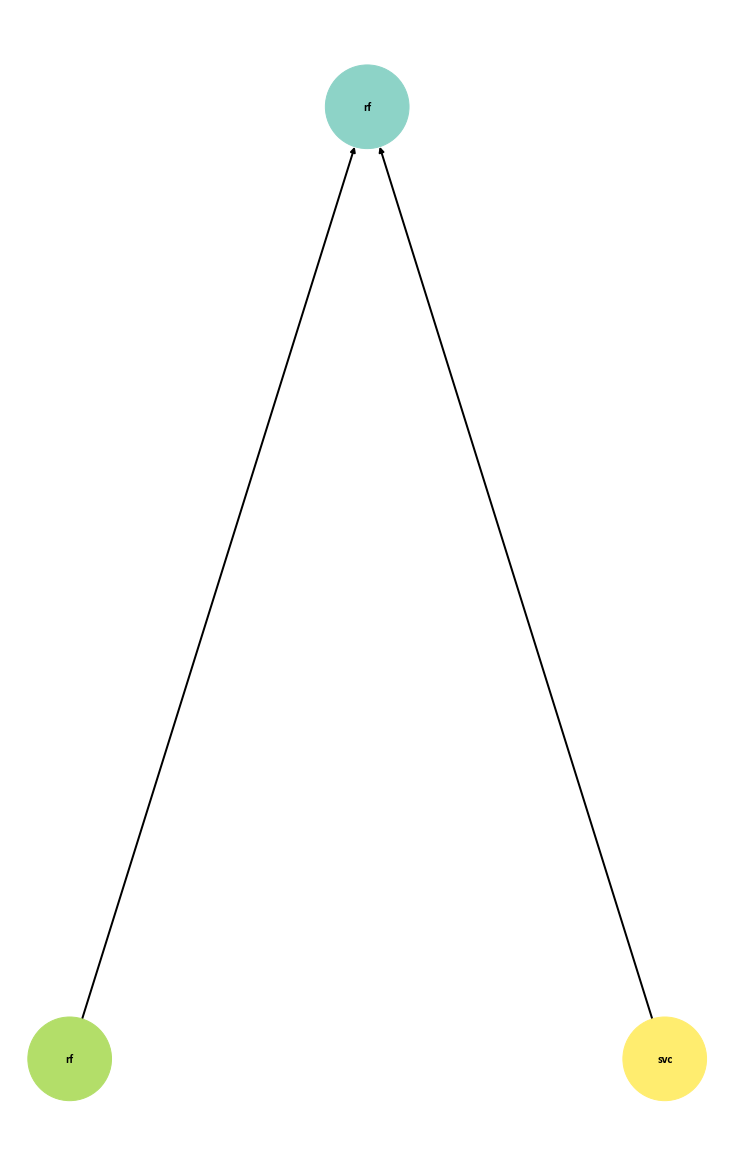

In [2]:
file_path_first = r'./creditcard_scaling_underSample.csv'
# file_path_first = r'./creditcard_under.csv'
# file_path_first = r'./creditcard.csv'

#examples/utils.py replace read_excel => read_csv
train_file_path, test_file_path = create_multi_clf_examples_from_excel(file_path_first)
test_data = InputData.from_csv(test_file_path)
#Error!!!!
fitted_model = get_model(train_file_path)

ComposerVisualiser.visualise(fitted_model, save_path = f'./model6.jpg')

roc_auc, roc, p, r, a = validate_model_quality(fitted_model, test_file_path)
print(f'ROC AUC metric is {roc_auc}, \nROC_AUC_ALL {roc}, \nPRECISION is {p}, \nRECALL is {r}, \nACCURACY is {a}')

#0.972 

In [52]:
file_path_second = r'./creditcard_scaling.csv'
# file_path_second = r'./examples/data/creditcard_under/test.csv'
roc, roc_auc_all, p, r, a = apply_model_to_data_and_predict(fitted_model, file_path_second)
print(f'ROC AUC metric is {roc}, ROC_AUC_ALL {roc_auc_all}, PRECISION is {p}, RECALL is {r}, ACCURACY is {a}')
#ROC AUC metric is 0.969, ROC_AUC_ALL 0.9693877551020409, PRECISION is 0.9263157894736842, RECALL is 0.8979591836734694, ACCURACY is 0.9137055837563451


ROC AUC metric is 0.9755855858947243, ROC_AUC_ALL 0.9618787253459999, PRECISION is 0.06067298947641939, RECALL is 0.9491869918699187, ACCURACY is 0.974526609247666


In [4]:
import pandas as pd
dat = pd.read_csv('creditcard_scaling_underSample.csv')
dat

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.293440,-0.906366,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,...,0.269773,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474,1
1,2.473276,0.553225,-1.099270,-0.401308,0.979359,-1.885112,-0.250168,-0.133203,0.545923,0.112715,...,0.618658,0.400881,0.679017,-0.078751,-0.520938,0.773371,-0.003025,-0.029610,0.089475,0
2,-0.296653,0.894959,-0.644278,5.002352,-8.252739,7.756915,-0.216267,-2.751496,-3.358857,1.406268,...,0.816558,0.587728,-0.605759,0.033746,-0.756170,-0.008172,0.532772,0.663970,0.192067,1
3,-0.181793,-0.294541,1.245674,0.166975,0.488306,0.635322,-0.562777,-1.011073,0.014953,-0.160211,...,-0.132080,-0.262581,-0.816264,0.140304,0.357827,0.186423,0.096544,-0.035866,0.018495,0
4,-0.293440,-0.087536,-5.129937,5.175102,-3.134030,1.116648,-1.694747,2.070258,-7.153496,-10.700534,...,2.684476,-5.912426,2.246010,1.010550,-0.567496,-0.610164,-0.410800,-0.915947,0.122155,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,0.525816,0.488128,1.967561,-1.212796,0.005362,-0.465616,-1.415820,0.061468,-1.329188,0.146808,...,-0.442374,-0.255835,-0.246727,0.300866,-0.341804,-0.706497,0.481806,0.002202,-0.036923,0
980,0.320687,0.458429,-1.195804,-0.257156,0.237545,-2.897071,1.398154,-1.497629,1.078211,-0.134459,...,0.053342,0.080830,0.010164,-0.479856,-0.477132,1.290695,-0.078257,-0.082718,0.021433,0
981,4.445050,-0.511684,-4.595617,5.083690,-7.581015,7.546033,-6.949165,-1.729185,-8.190192,2.714670,...,1.682160,2.248971,0.566844,0.033744,0.591783,0.334229,0.386801,2.163898,0.983104,1
982,1.174736,-0.961865,-1.199752,-0.820796,0.778836,1.687205,1.887818,1.124627,-0.231829,0.621685,...,0.516898,0.470337,1.167774,0.486281,-0.982305,-0.798267,-0.084967,0.232419,0.213574,0


In [25]:
from sklearn.utils import shuffle
df = shuffle(dat, random_state = 42).reset_index().drop(columns='index')

df.to_csv(r'.\creditcard_under_shuffle.csv', index=False)

In [21]:
full_data = InputData.from_csv(file_path_second)

ROC AUC metric is 0.975, PRECISION is 0.946236559139785, RECALL is 0.8979591836734694, ACCURACY is 0.9238578680203046 // model5

ROC AUC metric is 0.972, PRECISION is 0.9263157894736842, RECALL is 0.8979591836734694, ACCURACY is 0.9137055837563451 // model4

In [4]:
fitted_model.fitness

-0.9926783333333333

In [3]:
fitted_model.fitness

-0.9926783333333333

In [3]:
fitted_model.fitness

-0.9886876666666666

In [6]:
fitted_model.fitness

-0.9926783333333333

In [4]:
fitted_model.fitness

-0.9923379999999999

In [27]:
test_file_path

'C:\\Users\\Тимур.GAMESTATION\\vir\\Scripts\\FEDOT\\examples\\data\\creditcard_under\\test.csv'

In [20]:
test_2 = 'C:\\Users\\Тимур.GAMESTATION\\vir\\Scripts\\FEDOT\\examples\\data\\creditcard\\creditcard.csv'

In [21]:
def validate_model_quality(model: Chain, data_path: str):
    dataset_to_validate = InputData.from_csv(data_path)
    predicted_labels = model.predict(dataset_to_validate).predict

    roc_auc_valid = round(roc_auc(y_true=test_data.target,
                                  y_score=predicted_labels.round(),
                                  multi_class='ovo',
                                  average='macro'), 3)
    
    p = precision_score(y_true=test_data.target,y_pred=predicted_labels.round())
    r = recall_score(y_true=test_data.target, y_pred=predicted_labels.round())
    a = accuracy_score(y_true=test_data.target, y_pred=predicted_labels.round())
    
    return roc_auc_valid, p, r, a

roc_auc, p, r, a = validate_model_quality(fitted_model, test_2)

print(f'ROC AUC metric is {roc_auc}, PRECISION is {p}, RECALL is {r}, ACCURACY is {a}')


TypeError: 'numpy.float64' object is not callable

In [4]:
#mlp + xgboost + logit => mlp
#roc_auc = validate_model_quality(fitted_model, test_file_path)
print(f'ROC AUC metric is {roc_auc[0]}')
print(f'PRECISION metric is {roc_auc[1]}')
print(f'RECALL metric is {roc_auc[2]}')
print(f'ACCURACY metric is {roc_auc[3]}')

ROC AUC metric is 0.96
PRECISION metric is 0.946236559139785
RECALL metric is 0.8979591836734694
ACCURACY metric is 0.9238578680203046


In [36]:
# #mlp + xgboost + logit => mlp
# roc_auc = validate_model_quality(fitted_model, test_file_path)
# print(f'ROC AUC metric is {roc_auc[0]}')
# print(f'PRECISION metric is {roc_auc[1]}')
# print(f'RECALL metric is {roc_auc[2]}')
# print(f'ACCURACY metric is {roc_auc[3]}')

ROC AUC metric is 0.975
PRECISION metric is 0.9560439560439561
RECALL metric is 0.8877551020408163
ACCURACY metric is 0.9238578680203046


In [25]:
#direct_data_model + logit => rf
# print(f'ROC AUC metric is {roc_auc[0]}')
# print(f'PRECISION metric is {roc_auc[1]}')
# print(f'RECALL metric is {roc_auc[2]}')
# print(f'ACCURACY metric is {roc_auc[3]}')

ROC AUC metric is 0.978
PRECISION metric is 0.967032967032967
RECALL metric is 0.8979591836734694
ACCURACY metric is 0.934010152284264


In [22]:
#Одиночная MLP модель
# print(f'ROC AUC metric is {roc_auc[0]}')
# print(f'PRECISION metric is {roc_auc[1]}')
# print(f'RECALL metric is {roc_auc[2]}')
# print(f'ACCURACY metric is {roc_auc[3]}')

ROC AUC metric is 0.969
PRECISION metric is 0.9263157894736842
RECALL metric is 0.8979591836734694
ACCURACY metric is 0.9137055837563451


In [16]:
file_path_first = r'./creditcard_under.csv'

In [17]:
train_file_path, test_file_path = create_multi_clf_examples_from_excel(file_path_first)

In [18]:
test_data = InputData.from_csv(test_file_path)

In [19]:
task = Task(task_type=TaskTypesEnum.classification)
dataset_to_compose = InputData.from_csv(train_file_path, task=task)

In [20]:
models_repo = ModelTypesRepository()
available_model_types, _ = models_repo.suitable_model(task_type=task.task_type)

In [21]:
metric_function = MetricsRepository().metric_by_id(ClassificationMetricsEnum.ROCAUC_penalty)

In [22]:
metric_function

<bound method QualityMetric.get_value_with_penalty of <class 'core.composer.metrics.RocAucMetric'>>

In [9]:
#1
composer_requirements = GPComposerRequirements(
        primary=available_model_types, secondary=available_model_types,
        max_lead_time=timedelta(seconds=60))

In [45]:
#2
composer_requirements = GPComposerRequirements(
        primary='logit', secondary='rf',
        max_lead_time=timedelta(seconds=5))

In [23]:
#3
composer_requirements = GPComposerRequirements(
    primary=available_model_types,
    secondary=available_model_types, max_arity=2,
    max_depth=3, pop_size=10, num_of_generations=15,
    crossover_prob=0.8, mutation_prob=0.8, max_lead_time=timedelta(seconds=5))

In [24]:
composer = GPComposer()

In [25]:
available_model_types

['logit',
 'lda',
 'qda',
 'dt',
 'rf',
 'mlp',
 'knn',
 'svc',
 'xgboost',
 'bernb',
 'direct_data_model',
 'pca_data_model']

In [26]:
chain_evo_composed = composer.compose_chain(data=dataset_to_compose,
                                                initial_chain=None,
                                                composer_requirements=composer_requirements,
                                                metrics=metric_function, 
                                                is_visualise=False)

Error in chain assessment during composition: Invalid chain configuration: Chain has incorrect models positions. Continue.
Error in chain assessment during composition: Invalid chain configuration: Chain has incorrect models positions. Continue.
Error in chain assessment during composition: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.. Continue.
Generation num: 0
spent time: 0.3 min
Best metric is -0.98769
Composition time: 0.3 min
Algorithm was terminated due to processing time limit
GP composition finished


# Chain from autoML

In [47]:
def run_chain_from_automl(train_file_path: str, test_file_path: str,
                          max_run_time: timedelta = timedelta(minutes=10)):
    train_data = InputData.from_csv(train_file_path)
    test_data = InputData.from_csv(test_file_path)
node_logit.model.external_params = {'max_run_time_sec': max_run_time.seconds}
    testing_target = test_data.target

    #1 model
    chain = Chain()
    node_logit = PrimaryNode('logit')
    
    node_lda = PrimaryNode('lda')
    node_rf = SecondaryNode('rf')

    node_rf.nodes_from = [node_logit, node_lda]

    chain.add_node(node_rf)

    chain.fit(train_data)
    results = chain.predict(test_data)

    roc_auc_value = roc_auc(y_true=testing_target,
                            y_score=results.predict)
    
    
    p = precision_score(y_true=testing_target,y_pred=results.predict.round())
    r = recall_score(y_true=testing_target, y_pred=results.predict.round())
    a = accuracy_score(y_true=testing_target, y_pred=results.predict.round())
    
    print(roc_auc_value, p, r, a)

    return roc_auc_value

run_chain_from_automl(train_file_path, test_file_path)

0.9892853700379758 0.9971910112359551 0.9010152284263959 0.9998244420549057


0.9892853700379758

In [5]:
train_file_path, test_file_path

('C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\creditcard\\train.csv',
 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\creditcard\\test.csv')

In [11]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)


In [12]:
testing_target = test_data.target

In [27]:
chain = Chain()
node_tpot = PrimaryNode('logit')

In [28]:
node_tpot.model.external_params = {'max_run_time_sec': timedelta(10)}

In [29]:
node_lda = PrimaryNode('lda')
node_rf = SecondaryNode('rf')

In [30]:
node_rf.nodes_from = [node_tpot, node_lda]

In [31]:
chain.add_node(node_rf)

In [32]:
chain.fit(train_data)

OutputData(idx=array([223361., 165061., 238186., ..., 131932., 146867., 121958.]), features=array([[ 1.43352000e+05,  1.95504092e+00, -3.80782711e-01, ...,
         4.51682478e-02, -4.71447917e-02,  9.99000000e+00],
       [ 1.17173000e+05, -4.00975239e-01, -6.26942769e-01, ...,
        -3.70468822e-01, -1.44791686e-01,  4.59000000e+01],
       [ 1.49565000e+05,  7.25090164e-02,  8.20565650e-01, ...,
         2.06394866e-01,  7.02877702e-02,  1.19900000e+01],
       ...,
       [ 7.97950000e+04, -1.46608925e-01,  9.92946123e-01, ...,
        -1.21139194e-01, -1.96195328e-01,  3.94000000e+00],
       [ 8.79310000e+04, -2.94863809e+00,  2.35484929e+00, ...,
         4.96912107e-01,  3.35821632e-01,  1.00000000e+00],
       [ 7.63810000e+04,  1.23317435e+00, -7.84850501e-01, ...,
         1.21657270e-03,  3.85878912e-02,  1.13000000e+02]]), task=Task(task_type=<TaskTypesEnum.classification: ('classification',)>, task_params=None), data_type=<DataTypesEnum.table: 'feature_table'>, predict=

In [33]:
results = chain.predict(test_data)

In [34]:
roc_auc_value = roc_auc(y_true=testing_target,
                        y_score=results.predict)
print(roc_auc_value)

0.9887529521335848


# Chain tune

In [3]:
def chain_tuning(nodes_to_tune: str, chain: Chain, train_data: InputData,
                 test_data: InputData, local_iter: int,
                 tuner_iter_num: int = 50) -> (float, list):
    several_iter_scores_test = []

    if nodes_to_tune == 'primary':
        print('primary_node_tuning')
        chain_tune_strategy = chain.fine_tune_primary_nodes
    elif nodes_to_tune == 'root':
        print('root_node_tuning')
        chain_tune_strategy = chain.fine_tune_all_nodes
    else:
        raise ValueError(f'Invalid type of nodes. Nodes must be primary or root')

    for iteration in range(local_iter):
        print(f'current local iteration {iteration}')

        # Chain tuning
        chain_tune_strategy(train_data, iterations=tuner_iter_num)

        # After tuning prediction
        chain.fit(train_data)
        after_tuning_predicted = chain.predict(test_data)

        # Metrics
        aft_tun_roc_auc = roc_auc(y_true=test_data.target,
                                  y_score=after_tuning_predicted.predict)
        several_iter_scores_test.append(aft_tun_roc_auc)

    return float(np.mean(several_iter_scores_test)), several_iter_scores_test

In [6]:
#2 model
def get_simple_chain():
    first = PrimaryNode(model_type='logit')
    second = PrimaryNode(model_type='lda')
    final = SecondaryNode(model_type='rf',
                          nodes_from=[first, second])

    chain = Chain(final)

    return chain

In [7]:
file_path_first = r'./creditcard.csv'

In [8]:
train_file_path = 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\creditcard\\train.csv'
test_file_path = 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\creditcard\\test.csv'

In [9]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [10]:
chain = get_simple_chain()

In [11]:
chain.fit(train_data, use_cache=True)

OutputData(idx=array([223361., 165061., 238186., ..., 131932., 146867., 121958.]), features=array([[ 1.43352000e+05,  1.95504092e+00, -3.80782711e-01, ...,
         4.51682478e-02, -4.71447917e-02,  9.99000000e+00],
       [ 1.17173000e+05, -4.00975239e-01, -6.26942769e-01, ...,
        -3.70468822e-01, -1.44791686e-01,  4.59000000e+01],
       [ 1.49565000e+05,  7.25090164e-02,  8.20565650e-01, ...,
         2.06394866e-01,  7.02877702e-02,  1.19900000e+01],
       ...,
       [ 7.97950000e+04, -1.46608925e-01,  9.92946123e-01, ...,
        -1.21139194e-01, -1.96195328e-01,  3.94000000e+00],
       [ 8.79310000e+04, -2.94863809e+00,  2.35484929e+00, ...,
         4.96912107e-01,  3.35821632e-01,  1.00000000e+00],
       [ 7.63810000e+04,  1.23317435e+00, -7.84850501e-01, ...,
         1.21657270e-03,  3.85878912e-02,  1.13000000e+02]]), task=Task(task_type=<TaskTypesEnum.classification: ('classification',)>, task_params=None), data_type=<DataTypesEnum.table: 'feature_table'>, predict=

In [12]:
before_tuning_predicted = chain.predict(test_data)

In [13]:
bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)

In [14]:
print(round(bfr_tun_roc_auc, 10))

0.8283858264


In [15]:
p = precision_score(test_data.target,before_tuning_predicted.predict.round())
r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())

In [16]:
p, r, a

(0.7640449438202247, 0.6938775510204082, 0.9991046662687406)

In [15]:
#3 model
def get_simple_chain():
    first = PrimaryNode(model_type='xgboost')
    second = PrimaryNode(model_type='lda')
    final = SecondaryNode(model_type='rf',
                          nodes_from=[first, second])

    chain = Chain(final)

    return chain

In [16]:
file_path_first = r'./creditcard.csv'

In [17]:
train_file_path = 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\creditcard\\train.csv'
test_file_path = 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\creditcard\\test.csv'

In [18]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [19]:
chain = get_simple_chain()

In [20]:
chain.fit(train_data, use_cache=True)

OutputData(idx=array([223361., 165061., 238186., ..., 131932., 146867., 121958.]), features=array([[ 1.43352000e+05,  1.95504092e+00, -3.80782711e-01, ...,
         4.51682478e-02, -4.71447917e-02,  9.99000000e+00],
       [ 1.17173000e+05, -4.00975239e-01, -6.26942769e-01, ...,
        -3.70468822e-01, -1.44791686e-01,  4.59000000e+01],
       [ 1.49565000e+05,  7.25090164e-02,  8.20565650e-01, ...,
         2.06394866e-01,  7.02877702e-02,  1.19900000e+01],
       ...,
       [ 7.97950000e+04, -1.46608925e-01,  9.92946123e-01, ...,
        -1.21139194e-01, -1.96195328e-01,  3.94000000e+00],
       [ 8.79310000e+04, -2.94863809e+00,  2.35484929e+00, ...,
         4.96912107e-01,  3.35821632e-01,  1.00000000e+00],
       [ 7.63810000e+04,  1.23317435e+00, -7.84850501e-01, ...,
         1.21657270e-03,  3.85878912e-02,  1.13000000e+02]]), task=Task(task_type=<TaskTypesEnum.classification: ('classification',)>, task_params=None), data_type=<DataTypesEnum.table: 'feature_table'>, predict=

In [21]:
before_tuning_predicted = chain.predict(test_data)

In [22]:
bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)

In [23]:
print(round(bfr_tun_roc_auc, 10))

1.0


In [24]:
f1_score(test_data.target,before_tuning_predicted.predict.round())

1.0

In [25]:
p = precision_score(test_data.target,before_tuning_predicted.predict.round())
r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())

In [26]:
p, r, a

(1.0, 1.0, 1.0)

# Balanced classes to Under

In [2]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
file_path_first = r'./creditcard.csv'

In [4]:
file_path_first

'./creditcard.csv'

In [5]:
df, full_file_path = create_multi_clf_examples_from_excel(file_path_first, return_df=True)

In [6]:
test_data = InputData.from_csv(full_file_path)

In [7]:
import pandas as pd
df = pd.read_csv('creditcard.csv')

In [8]:
df.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [9]:
X = df.drop(columns=['Class'])
y = df.iloc[:,[-1]]

In [10]:
rus = RandomUnderSampler(random_state=42)

In [11]:
X_res, y_res = rus.fit_resample(X, y)
X_res['Class'] = y_res

In [12]:
X_res

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,82450.0,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,...,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0.76,0
1,50554.0,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,...,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,4.18,0
2,55125.0,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,...,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,15.00,0
3,116572.0,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,...,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,57.00,0
4,90434.0,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,...,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
980,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
981,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
982,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [15]:
X_res.to_csv(r'.\creditcard_under.csv', index=False)

# Balanced classes to Over

In [30]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


In [31]:
file_path_first = r'./creditcard.csv'

In [32]:
file_path_first

'./creditcard.csv'

In [34]:
df, full_file_path = create_multi_clf_examples_from_excel(file_path_first, return_df=True)

In [35]:
test_data = InputData.from_csv(full_file_path)

In [36]:
test_data.target

array([0., 0., 0., ..., 0., 0., 0.])

In [37]:
import pandas as pd
df = pd.read_csv('creditcard.csv')

In [38]:
df.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [39]:
X = df.drop(columns=['Class'])
y = df.iloc[:,[-1]]

In [40]:
rus = RandomOverSampler(random_state=42)

In [41]:
X_res, y_res = rus.fit_resample(X, y)
X_res['Class'] = y_res

In [42]:
X_res

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,34521.0,1.081234,0.416414,0.862919,2.520863,-0.005021,0.563341,-0.123372,0.223122,-0.673598,...,-0.159387,-0.305154,0.053620,0.011761,0.375146,-0.106299,0.021008,0.010559,1.52,1
568626,53658.0,-1.739341,1.344521,-0.534379,3.195291,-0.416196,-1.261961,-2.340991,0.713004,-1.416265,...,0.383180,-0.213952,-0.336640,0.237076,0.246003,-0.044228,0.510729,0.220952,0.00,1
568627,34687.0,-0.860827,3.131790,-5.052968,5.420941,-2.494141,-1.811287,-5.479117,1.189472,-3.908206,...,1.192694,0.090356,-0.341881,-0.215924,1.053032,0.271139,1.373300,0.691195,19.02,1
568628,40276.0,1.159373,2.844795,-4.050680,4.777701,2.948980,-2.010361,1.744086,-0.410287,-2.450198,...,-0.176541,-0.433470,-0.529323,-0.597020,1.335954,0.547092,0.009979,0.160769,1.00,1


In [43]:
X_res.to_csv(r'C:\Users\Тимур\vir\Scripts\Fedot\export_dataframe_over.csv', index=False)

# Train on balanced under

In [27]:
file_path_first = r'./export_dataframe.csv'

In [28]:
train_file_path, test_file_path = create_multi_clf_examples_from_excel(file_path_first)

In [29]:
train_file_path, test_file_path

('C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\export_dataframe\\train.csv',
 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\export_dataframe\\test.csv')

In [30]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [31]:
test_data

InputData(idx=array([613., 451., 731., 436., 275., 582., 707., 299., 718., 494., 351.,
       594., 652., 865., 294.,  66., 377., 682., 755., 107., 139.,  67.,
       832., 213., 670., 486., 425., 363.,  76., 298.,  88.,  59., 420.,
       237., 848., 221., 362.,  23.,  30., 477., 266., 168., 589., 281.,
       493., 643., 669., 479., 280., 535., 778., 490., 758., 734., 588.,
       660., 630., 440., 899., 859., 136.,  39., 359., 244., 296., 355.,
       937.,  70., 449., 920., 342., 312., 158., 761., 946., 310., 853.,
        63., 813., 199., 593., 516., 712., 928.,  96., 959., 321., 542.,
       789., 969., 120.,  86., 570., 547., 878., 558., 533., 668., 689.,
       615., 887., 792., 254., 909., 921., 798., 184., 836., 819., 979.,
       522.,  55., 746., 247., 869., 260.,  72., 655.,  44., 915., 218.,
       618., 286., 694., 567., 823., 807., 314., 215., 678., 635., 519.,
       394., 259., 926., 333., 465.,  60., 521., 587., 730., 852., 585.,
       370., 500., 290., 198., 305., 

In [32]:
def get_simple_chain():
    first = PrimaryNode(model_type='logit')
    second = PrimaryNode(model_type='lda')
    final = SecondaryNode(model_type='rf',
                          nodes_from=[first, second])

    chain = Chain(final)

    return chain

In [33]:
chain = get_simple_chain()

In [34]:
chain.fit(train_data, use_cache=False)

OutputData(idx=array([962., 762., 334., 889., 529., 468., 978., 231., 568.,  33.,  31.,
       736., 192., 318., 495., 933., 309., 934., 715., 109., 411.,  77.,
       680., 923.,  82., 404., 331., 605., 382., 539., 845.,   2., 101.,
       371., 462., 453., 208., 884.,   5.,  54., 307., 857., 811., 447.,
        97., 597., 204., 514., 628., 944., 527., 344., 854.,  25.,  84.,
        10., 892., 770., 621., 365., 752., 118., 350., 250., 705., 940.,
       196., 596.,  81., 958., 457., 611., 239., 277., 211., 708., 858.,
       713., 227., 842., 497., 785., 482., 636., 346., 450., 824., 352.,
         7., 155., 534., 422., 704., 380., 767., 559., 319., 591., 919.,
       398., 523., 809., 501., 430., 982., 228., 764., 876., 212.,  79.,
       148., 302., 545., 536., 327., 973., 799., 133., 543., 311., 599.,
       423.,   0., 316., 697., 797., 328., 525., 970., 433., 172., 125.,
       541., 879., 888.,  90., 924., 181., 274., 880.,  69., 291., 131.,
       300., 802., 326., 144., 405.,

In [35]:
before_tuning_predicted = chain.predict(test_data)

In [36]:
bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)
print(round(bfr_tun_roc_auc, 10))

0.9585137085


In [37]:
p = precision_score(test_data.target,before_tuning_predicted.predict.round())
r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
p, r, a

(0.9456521739130435, 0.8877551020408163, 0.9187817258883249)

In [17]:
def run_chain_from_automl(train_file_path: str, test_file_path: str,
                          max_run_time: timedelta = timedelta(minutes=10)):
    train_data = InputData.from_csv(train_file_path)
    test_data = InputData.from_csv(test_file_path)
    
    
    testing_target = test_data.target

    #1 model
    chain = Chain()
    node_logit = PrimaryNode('logit')
    node_logit.model.external_params = {'max_run_time_sec': max_run_time.seconds}
    
    node_lda = PrimaryNode('lda')
    node_rf = SecondaryNode('rf')

    node_rf.nodes_from = [node_logit, node_lda]

    chain.add_node(node_rf)

    chain.fit(train_data)
    results = chain.predict(test_data)

    roc_auc_value = roc_auc(y_true=testing_target,
                            y_score=results.predict)
    
    
    p = precision_score(y_true=testing_target,y_pred=results.predict.round())
    r = recall_score(y_true=testing_target, y_pred=results.predict.round())
    a = accuracy_score(y_true=testing_target, y_pred=results.predict.round())
    
    print(roc_auc_value, p, r, a)

    return roc_auc_value

run_chain_from_automl(train_file_path, test_file_path)

0.8183704334294213 0.7586206896551724 0.673469387755102 0.9990695551420246


0.8183704334294213

# Train on balanced over

In [18]:
file_path_first = r'./export_dataframe_over.csv'

In [19]:
train_file_path, test_file_path = create_multi_clf_examples_from_excel(file_path_first)

In [20]:
train_file_path, test_file_path

('C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\export_dataframe_over\\train.csv',
 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\export_dataframe_over\\test.csv')

In [21]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [28]:
def get_simple_chain():
    first = PrimaryNode(model_type='logit')
    second = PrimaryNode(model_type='lda')
    final = SecondaryNode(model_type='rf',
                          nodes_from=[first, second])

    chain = Chain(final)

    return chain

In [29]:
chain = get_simple_chain()

In [30]:
chain.fit(train_data, use_cache=False)

OutputData(idx=array([ 93824.,  39017., 150139., ...,  62341.,  79795.,  76381.]), features=array([[-3.63280895e+00,  5.43726336e+00, -9.13652148e+00, ...,
         1.69360751e+00,  8.57685372e-01,  8.54000000e+00],
       [-5.86021027e-01, -3.19820450e-02,  2.15357484e+00, ...,
        -1.85795736e-01, -1.29465135e-01,  2.54100000e+01],
       [-6.68283192e+00, -2.71426804e+00, -5.77453046e+00, ...,
        -5.49876280e-02,  8.23370925e-02,  2.37260000e+02],
       ...,
       [-5.26775974e+00,  2.50671896e+00, -5.29092482e+00, ...,
        -1.48676592e+00,  6.77664105e-01,  1.10000000e+00],
       [-1.46608925e-01,  9.92946123e-01,  1.52459137e+00, ...,
        -1.21139194e-01, -1.96195328e-01,  3.94000000e+00],
       [ 1.23317435e+00, -7.84850501e-01,  3.86783869e-01, ...,
         1.21657270e-03,  3.85878912e-02,  1.13000000e+02]]), task=Task(task_type=<TaskTypesEnum.classification: ('classification',)>, task_params=None), data_type=<DataTypesEnum.table: 'feature_table'>, predict=

In [31]:
before_tuning_predicted = chain.predict(test_data)

In [32]:
bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)
print(round(bfr_tun_roc_auc, 10))

0.9999537225


In [33]:
p = precision_score(test_data.target,before_tuning_predicted.predict.round())
r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
p, r, a

(0.9995781569677923, 1.0, 0.9997889664632538)

In [34]:
def run_chain_from_automl(train_file_path: str, test_file_path: str,
                          max_run_time: timedelta = timedelta(minutes=10)):
    train_data = InputData.from_csv(train_file_path)
    test_data = InputData.from_csv(test_file_path)
    
    
    testing_target = test_data.target

    #1 model
    chain = Chain()
    node_logit = PrimaryNode('logit')
    node_logit.model.external_params = {'max_run_time_sec': max_run_time.seconds}
    
    node_lda = PrimaryNode('lda')
    node_rf = SecondaryNode('rf')

    node_rf.nodes_from = [node_logit, node_lda]

    chain.add_node(node_rf)

    chain.fit(train_data)
    results = chain.predict(test_data)

    roc_auc_value = roc_auc(y_true=testing_target,
                            y_score=results.predict)
    
    
    p = precision_score(y_true=testing_target,y_pred=results.predict.round())
    r = recall_score(y_true=testing_target, y_pred=results.predict.round())
    a = accuracy_score(y_true=testing_target, y_pred=results.predict.round())
    
    print(roc_auc_value, p, r, a)

    return roc_auc_value

run_chain_from_automl(train_file_path, test_file_path)

0.9999577180524802 0.9995641016627412 1.0 0.9997819320120289


0.9999577180524802

# Train on balanced predict on full

In [17]:
file_path_first = r'./export_dataframe.csv'

In [18]:
train_file_path, test_file_path = create_multi_clf_examples_from_excel(file_path_first)

In [19]:
train_file_path, test_file_path

('C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\export_dataframe\\train.csv',
 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\export_dataframe\\test.csv')

In [41]:
import pandas as pd
data1 = pd.read_csv('creditcard.csv')
data1.to_csv(r'C:\Users\Тимур\vir\Scripts\Fedot\creditcard_with_index.csv', index=True)

In [20]:
test_file_path = r'./creditcard_with_index.csv'

In [21]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [45]:
def get_simple_chain():
    first = PrimaryNode(model_type='logit')
    second = PrimaryNode(model_type='lda')
    final = SecondaryNode(model_type='rf',
                          nodes_from=[first, second])

    chain = Chain(final)

    return chain

In [46]:
chain = get_simple_chain()

In [47]:
chain.fit(train_data, use_cache=False)

OutputData(idx=array([962., 762., 334., 889., 529., 468., 978., 231., 568.,  33.,  31.,
       736., 192., 318., 495., 933., 309., 934., 715., 109., 411.,  77.,
       680., 923.,  82., 404., 331., 605., 382., 539., 845.,   2., 101.,
       371., 462., 453., 208., 884.,   5.,  54., 307., 857., 811., 447.,
        97., 597., 204., 514., 628., 944., 527., 344., 854.,  25.,  84.,
        10., 892., 770., 621., 365., 752., 118., 350., 250., 705., 940.,
       196., 596.,  81., 958., 457., 611., 239., 277., 211., 708., 858.,
       713., 227., 842., 497., 785., 482., 636., 346., 450., 824., 352.,
         7., 155., 534., 422., 704., 380., 767., 559., 319., 591., 919.,
       398., 523., 809., 501., 430., 982., 228., 764., 876., 212.,  79.,
       148., 302., 545., 536., 327., 973., 799., 133., 543., 311., 599.,
       423.,   0., 316., 697., 797., 328., 525., 970., 433., 172., 125.,
       541., 879., 888.,  90., 924., 181., 274., 880.,  69., 291., 131.,
       300., 802., 326., 144., 405.,

In [48]:
before_tuning_predicted = chain.predict(test_data)

In [49]:
bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)
print(round(bfr_tun_roc_auc, 10))

0.9854838022


In [61]:
p = precision_score(y_true=test_data.target,y_pred=before_tuning_predicted.predict.round())
r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
p, r, a

(0.03659277254782873, 0.9796747967479674, 0.9554083993722065)

In [62]:
482/(482+12690)

0.03659277254782873

In [56]:
before_tuning_predicted.predict

array([0.2 , 0.09, 0.23, ..., 0.  , 0.  , 0.17])

In [57]:
confusion_matrix(test_data.target, before_tuning_predicted.predict.round())

array([[271625,  12690],
       [    10,    482]], dtype=int64)

In [64]:
482/(482+10)

0.9796747967479674

In [67]:
report = classification_report(y_true=test_data.target,y_pred=before_tuning_predicted.predict.round())
print(report)

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98    284315
         1.0       0.04      0.98      0.07       492

    accuracy                           0.96    284807
   macro avg       0.52      0.97      0.52    284807
weighted avg       1.00      0.96      0.98    284807



In [51]:
def run_chain_from_automl(train_file_path: str, test_file_path: str,
                          max_run_time: timedelta = timedelta(minutes=10)):
    train_data = InputData.from_csv(train_file_path)
    test_data = InputData.from_csv(test_file_path)
    
    
    testing_target = test_data.target

    #1 model
    chain = Chain()
    node_logit = PrimaryNode('logit')
    node_logit.model.external_params = {'max_run_time_sec': max_run_time.seconds}
    
    node_lda = PrimaryNode('lda')
    node_rf = SecondaryNode('rf')

    node_rf.nodes_from = [node_logit, node_lda]

    chain.add_node(node_rf)

    chain.fit(train_data)
    results = chain.predict(test_data)

    roc_auc_value = roc_auc(y_true=testing_target,
                            y_score=results.predict)
    
    
    p = precision_score(y_true=testing_target,y_pred=results.predict.round())
    r = recall_score(y_true=testing_target, y_pred=results.predict.round())
    a = accuracy_score(y_true=testing_target, y_pred=results.predict.round())
    
    print(roc_auc_value, p, r, a)

    return roc_auc_value

run_chain_from_automl(train_file_path, test_file_path)

0.9856229113792114 0.03766507775259827 0.9796747967479674 0.9567250804931059


0.9856229113792114

# Simple models

In [10]:
file_path_first = r'./export_dataframe.csv'

In [11]:
train_file_path, test_file_path = create_multi_clf_examples_from_excel(file_path_first)

In [12]:
train_file_path, test_file_path

('C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\export_dataframe\\train.csv',
 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\export_dataframe\\test.csv')

In [13]:
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [17]:
def get_simple_chain():
#     first = PrimaryNode(model_type='logit')
#     second = PrimaryNode(model_type='lda')
    final = PrimaryNode(model_type='rf') #,
                          #nodes_from=[first, second])

    chain = Chain(final)

    return chain

In [18]:
chain = get_simple_chain()

In [19]:
chain.fit(train_data, use_cache=False)

OutputData(idx=array([962., 762., 334., 889., 529., 468., 978., 231., 568.,  33.,  31.,
       736., 192., 318., 495., 933., 309., 934., 715., 109., 411.,  77.,
       680., 923.,  82., 404., 331., 605., 382., 539., 845.,   2., 101.,
       371., 462., 453., 208., 884.,   5.,  54., 307., 857., 811., 447.,
        97., 597., 204., 514., 628., 944., 527., 344., 854.,  25.,  84.,
        10., 892., 770., 621., 365., 752., 118., 350., 250., 705., 940.,
       196., 596.,  81., 958., 457., 611., 239., 277., 211., 708., 858.,
       713., 227., 842., 497., 785., 482., 636., 346., 450., 824., 352.,
         7., 155., 534., 422., 704., 380., 767., 559., 319., 591., 919.,
       398., 523., 809., 501., 430., 982., 228., 764., 876., 212.,  79.,
       148., 302., 545., 536., 327., 973., 799., 133., 543., 311., 599.,
       423.,   0., 316., 697., 797., 328., 525., 970., 433., 172., 125.,
       541., 879., 888.,  90., 924., 181., 274., 880.,  69., 291., 131.,
       300., 802., 326., 144., 405.,

In [20]:
before_tuning_predicted = chain.predict(test_data)

In [21]:
bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)
print(round(bfr_tun_roc_auc, 10))

0.9788188002


In [22]:
p = precision_score(test_data.target,before_tuning_predicted.predict.round())
r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
p, r, a

(0.9560439560439561, 0.8877551020408163, 0.9238578680203046)

In [26]:
available_model_types

['logit',
 'lda',
 'qda',
 'dt',
 'rf',
 'mlp',
 'knn',
 'svc',
 'xgboost',
 'bernb',
 'direct_data_model']

In [36]:
available_model_types[0]

'logit'

In [23]:
def get_simple_chain(model_type):
    
    final = PrimaryNode(model_type='{}'.format(model_type))                    
    chain = Chain(final)

    return chain

In [31]:
chain = get_simple_chain('rf')

In [32]:
chain.fit(train_data, use_cache=False)

OutputData(idx=array([962., 762., 334., 889., 529., 468., 978., 231., 568.,  33.,  31.,
       736., 192., 318., 495., 933., 309., 934., 715., 109., 411.,  77.,
       680., 923.,  82., 404., 331., 605., 382., 539., 845.,   2., 101.,
       371., 462., 453., 208., 884.,   5.,  54., 307., 857., 811., 447.,
        97., 597., 204., 514., 628., 944., 527., 344., 854.,  25.,  84.,
        10., 892., 770., 621., 365., 752., 118., 350., 250., 705., 940.,
       196., 596.,  81., 958., 457., 611., 239., 277., 211., 708., 858.,
       713., 227., 842., 497., 785., 482., 636., 346., 450., 824., 352.,
         7., 155., 534., 422., 704., 380., 767., 559., 319., 591., 919.,
       398., 523., 809., 501., 430., 982., 228., 764., 876., 212.,  79.,
       148., 302., 545., 536., 327., 973., 799., 133., 543., 311., 599.,
       423.,   0., 316., 697., 797., 328., 525., 970., 433., 172., 125.,
       541., 879., 888.,  90., 924., 181., 274., 880.,  69., 291., 131.,
       300., 802., 326., 144., 405.,

In [33]:
before_tuning_predicted = chain.predict(test_data)

In [34]:
bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)
print(round(bfr_tun_roc_auc, 10))

0.9725314368


In [35]:
p = precision_score(test_data.target,before_tuning_predicted.predict.round())
r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
p, r, a

(0.945054945054945, 0.8775510204081632, 0.9137055837563451)

In [18]:
available_model_types.remove('knn')

In [8]:
available_model_types[-3]

'xgboost'

In [41]:
for model in available_model_types[:-1]:
    chain = get_simple_chain(model)
    chain.fit(train_data, use_cache=False)
    before_tuning_predicted = chain.predict(test_data)
    bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)
    p = precision_score(test_data.target,before_tuning_predicted.predict.round())
    r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
    a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
    print(model, ': roc_auc is ', round(bfr_tun_roc_auc, 10))
    print(model, ': precision is ', p)
    print(model, ': recall is ', r)
    print(model, ': accuracy is ', a, '\n')
    

logit : roc_auc is  0.9692846836
logit : precision is  0.9565217391304348
logit : recall is  0.8979591836734694
logit : accuracy is  0.9289340101522843 

lda : roc_auc is  0.9580498866
lda : precision is  0.9876543209876543
lda : recall is  0.8163265306122449
lda : accuracy is  0.9035532994923858 

qda : roc_auc is  0.9612451041
qda : precision is  0.9354838709677419
qda : recall is  0.8877551020408163
qda : accuracy is  0.9137055837563451 

dt : roc_auc is  0.9032673676
dt : precision is  0.9540229885057471
dt : recall is  0.8469387755102041
dt : accuracy is  0.9035532994923858 

rf : roc_auc is  0.9788188002
rf : precision is  0.946236559139785
rf : recall is  0.8979591836734694
rf : accuracy is  0.9238578680203046 

mlp : roc_auc is  0.9633065347
mlp : precision is  0.9361702127659575
mlp : recall is  0.8979591836734694
mlp : accuracy is  0.9187817258883249 

knn : roc_auc is  0.9545454545
knn : precision is  0.9555555555555556
knn : recall is  0.8775510204081632
knn : accuracy is  

In [12]:
train_file_path = 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\creditcard\\train.csv'
test_file_path = 'C:\\Users\\Тимур\\vir\\Scripts\\Fedot\\examples\\data\\creditcard\\test.csv'
train_data = InputData.from_csv(train_file_path)
test_data = InputData.from_csv(test_file_path)

In [14]:
for model in available_model_types[:-1]:
    chain = get_simple_chain(model)
    chain.fit(train_data, use_cache=False)
    before_tuning_predicted = chain.predict(test_data)
    bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)
    p = precision_score(test_data.target,before_tuning_predicted.predict.round())
    r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
    a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
    print(model, ': roc_auc is ', round(bfr_tun_roc_auc, 10))
    print(model, ': precision is ', p)
    print(model, ': recall is ', r)
    print(model, ': accuracy is ', a, '\n')
    

ValueError: Model b not found

In [ ]:
chain = get_simple_chain('svc')
chain.fit(train_data, use_cache=False)
before_tuning_predicted = chain.predict(test_data)
bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                      y_score=before_tuning_predicted.predict)
p = precision_score(test_data.target,before_tuning_predicted.predict.round())
r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
model = 'mod'
print(model, ': roc_auc is ', round(bfr_tun_roc_auc, 10))
print(model, ': precision is ', p)
print(model, ': recall is ', r)
print(model, ': accuracy is ', a, '\n')

In [25]:
(round(bfr_tun_roc_auc, 10), p, r, a)

(0.9999999663, 0.9998596097150078, 1.0, 0.9999296554877513)

In [ ]:
for model in available_model_types[:-1]:
    chain = get_simple_chain(model)
    chain.fit(train_data, use_cache=False)
    before_tuning_predicted = chain.predict(test_data)
    bfr_tun_roc_auc = roc_auc(y_true=test_data.target,
                          y_score=before_tuning_predicted.predict)
    p = precision_score(test_data.target,before_tuning_predicted.predict.round())
    r = recall_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
    a = accuracy_score(y_true=test_data.target, y_pred=before_tuning_predicted.predict.round())
    print(model, ': roc_auc is ', round(bfr_tun_roc_auc, 10))
    print(model, ': precision is ', p)
    print(model, ': recall is ', r)
    print(model, ': accuracy is ', a, '\n')
    

logit : roc_auc is  0.9872483007
logit : precision is  0.975940548072457
logit : recall is  0.9219671440606572
logit : accuracy is  0.9495190193974993 

lda : roc_auc is  0.9752322276
lda : precision is  0.9850909090909091
lda : recall is  0.8558340353833193
lda : accuracy is  0.9212844907936619 

qda : roc_auc is  0.9748670447
qda : precision is  0.9617988577480238
qda : recall is  0.8926214546475709
qda : accuracy is  0.9284420449149711 

dt : roc_auc is  0.999753304
dt : precision is  0.9995088063995509
dt : recall is  1.0
dt : accuracy is  0.9997537942071294 

rf : roc_auc is  1.0
rf : precision is  0.9999297999297999
rf : recall is  1.0
rf : accuracy is  0.9999648277438756 

mlp : roc_auc is  0.9999723312
mlp : precision is  0.9994036134011577
mlp : recall is  1.0
mlp : accuracy is  0.9997010358229429 



# DataPreprocess from Kaggle

In [33]:
import pandas as pd
df = pd.read_csv('creditcard.csv')

In [34]:
rob_scaler = RobustScaler()
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [35]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [36]:
df.shape

(284807, 31)

In [37]:
df.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [24]:
from imblearn.under_sampling import RandomUnderSampler

In [25]:
rus = RandomUnderSampler(sampling_strategy = 'all', random_state=42, replacement = True)

In [38]:
from imblearn.over_sampling import RandomOverSampler

In [40]:
rus = RandomOverSampler(sampling_strategy = 'all', random_state=42)

In [41]:
X = df.drop(columns=['Class'])
y = df.iloc[:,[-1]]

In [42]:
X_res, y_res = rus.fit_resample(X, y)
X_res['Class'] = y_res

In [43]:
X_res

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,-0.286173,-0.589422,1.081234,0.416414,0.862919,2.520863,-0.005021,0.563341,-0.123372,0.223122,...,-0.165249,-0.159387,-0.305154,0.053620,0.011761,0.375146,-0.106299,0.021008,0.010559,1
568626,-0.307413,-0.364595,-1.739341,1.344521,-0.534379,3.195291,-0.416196,-1.261961,-2.340991,0.713004,...,0.002749,0.383180,-0.213952,-0.336640,0.237076,0.246003,-0.044228,0.510729,0.220952,1
568627,-0.041640,-0.587472,-0.860827,3.131790,-5.052968,5.420941,-2.494141,-1.811287,-5.479117,1.189472,...,1.085760,1.192694,0.090356,-0.341881,-0.215924,1.053032,0.271139,1.373300,0.691195,1
568628,-0.293440,-0.521811,1.159373,2.844795,-4.050680,4.777701,2.948980,-2.010361,1.744086,-0.410287,...,-0.059264,-0.176541,-0.433470,-0.529323,-0.597020,1.335954,0.547092,0.009979,0.160769,1


In [44]:
from sklearn.utils import shuffle
df_1 = shuffle(X_res, random_state = 42).reset_index().drop(columns='index')

In [45]:
df_1

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.813526,0.303810,-2.450367,2.107729,-5.140663,1.411304,-1.690780,-0.736427,-3.657946,1.944906,...,-0.130438,0.800538,0.364617,0.233608,-0.282078,-0.320311,0.492920,0.359976,-0.115471,1
1,-0.293440,-0.501662,-4.566342,3.353451,-4.572028,3.616119,-2.493138,-1.090000,-5.551433,0.447783,...,-0.249128,2.674466,-0.020880,-0.302447,-0.086396,-0.516060,-0.295102,0.195985,0.141115,1
2,0.119192,-0.944854,-0.851994,0.935553,2.188136,0.709286,0.178930,-0.349335,0.857609,-0.416252,...,0.270933,-0.411022,-0.404762,-0.096893,0.404476,0.377388,0.344173,-0.000311,-0.125090,0
3,9.798225,0.544320,0.469750,-1.237555,-1.767341,4.833490,-0.268715,-0.512760,1.140149,-0.341273,...,1.277315,0.303905,-0.647075,-0.373014,0.260801,-0.496566,-0.245973,-0.117858,0.144774,1
4,-0.191434,0.639399,-3.975939,-1.244939,-3.707414,4.544772,4.050676,-3.407679,-5.063118,1.007042,...,2.109403,1.059737,-0.037395,0.348707,-0.162929,0.410531,-0.123612,0.877424,0.667568,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,1.578984,-0.152046,0.960530,-1.006608,0.799673,-1.216255,-1.541568,-0.670999,-0.610605,0.058303,...,0.171371,0.254714,0.653521,-0.204047,0.621861,0.370590,0.070796,0.015218,0.037579,0
568626,0.939426,0.872990,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,...,-0.295730,0.037078,-0.019575,0.241830,0.682820,-1.635109,-0.770941,0.066006,0.137056,0
568627,-0.292042,-0.262585,-5.267760,2.506719,-5.290925,4.886134,-3.343188,-1.100085,-5.810509,1.726343,...,-0.286043,0.764266,0.473262,0.548482,-0.156850,-0.710187,-0.366423,-1.486766,0.677664,1
568628,-0.252358,-0.057531,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,...,0.007155,0.052649,0.354089,-0.291198,0.402849,0.237383,-0.398467,-0.121139,-0.196195,0


In [46]:
df_1.to_csv(r'./creditcard_scaling_overSample.csv', index=False)